# Semantic Search on Tattoos


## Data preparation


In [1]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import CrossEncoder
from dotenv import load_dotenv
from datasets import Dataset
import pandas as pd
import requests
import torch
import json
import os

load_dotenv()

True

In [3]:
# question = "Give me 3 ideas of a tattoo of a cat in space?"
question = f"Give me very short summary of all tattoos containing cat. Summary must be up to 3 sentences."

In [4]:
image_df = pd.read_csv('data.csv')[['post_id', 'subreddit', 'image_path']]

old_prefix = '/net/pr2/projects/plgrid/plggtattooai'
new_prefix = '/Users/ewojcik/Code/pwr/AMC/amc-lab3/data'
image_df['image_path'] = image_df['image_path'].str.replace(old_prefix, new_prefix)

image_df

,post_id,subreddit,image_path
0,11tj1ya,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
1,uyp3wc,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
2,de326x,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
3,94gpbt,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
4,108rdjd,tattoos,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
...,...,...,...
78618,18k69hq,tattooadvice,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
78619,1ba61b8,tattooadvice,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
78620,1cea717,tattooadvice,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...
78621,12b3npz,tattooadvice,/Users/ewojcik/Code/pwr/AMC/amc-lab3/data/down...


In [5]:
descriptions_df = pd.read_csv('data.csv')[['post_id', 'tattoo_description','tattoo_color', 'tattoo_style', 'Title']]
descriptions_df

,post_id,tattoo_description,tattoo_color,tattoo_style,Title
0,11tj1ya,blackwork tattoo with intricate designs on the...,black,blackwork,Palm sleeves tattoos done by Chris at Timeless...
1,uyp3wc,colorful illustrative tattoo with various shap...,multicolored,illustrative,How it started and how its going. A map to esc...
2,de326x,blackwork tattoo featuring two raccoons with g...,black,blackwork,"Raccoon and otter by Shaun Horlock, Black Lodg..."
3,94gpbt,a watercolor tattoo of a landscape scene withi...,blue,illustrative,Got my first tattoo in four years from the ama...
4,108rdjd,animestyle tattoo with red tears and black eye...,red black,anime,"My Kill Bill thigh piece, by Nikol Safronova a..."
...,...,...,...,...,...
78618,18k69hq,a traditional tattoo featuring a heart with ey...,red black yellow,traditional,does this look normal?
78619,1ba61b8,black floral tattoo on the arm,black,blackwork,how much to tip
78620,1cea717,black fine line floral tattoo on the inner for...,black,fine line,First Tattoo is missing something...
78621,12b3npz,blackwork floral and butterfly tattoo on the r...,black,blackwork,Is it too jumbled up? I like it sometimes and ...


### Merge Posts


In [6]:
if not os.path.exists('tattoos/posts_content.csv'):
    # Get all CSV files in the specified directory
    csv_path = 'tattoos/posts_per_subreddit'
    csv_files = [f for f in os.listdir(csv_path) if f.endswith('.csv')]

    # Initialize empty DataFrame
    posts_content_df = pd.DataFrame()

    # Read and concatenate each CSV file
    for file in csv_files:
        file_path = os.path.join(csv_path, file)
        df = pd.read_csv(file_path)
        posts_content_df = pd.concat([posts_content_df, df], ignore_index=True)

    posts_content_df = posts_content_df[['Id', 'Content']]
    # Replace NaN values in 'Content' column with empty string
    posts_content_df['Content'] = posts_content_df['Content'].fillna('')
    posts_content_df = posts_content_df.rename(columns={'Id': 'post_id'})

    posts_content_df.to_csv('tattoos/posts_content.csv')
else:
    posts_content_df = pd.read_csv('tattoos/posts_content.csv')
    # Replace NaN values in 'Content' column with empty string
    posts_content_df['Content'] = posts_content_df['Content'].fillna('')

In [7]:
posts_content_df

,Unnamed: 0,post_id,Content
0,0,2zbp4x,
1,1,2zeq1l,
2,2,2zfjp4,
3,3,2zizqs,
4,4,2zlsqy,
...,...,...,...
332450,332450,1gk2hyh,
332451,332451,1gk33iq,"This is my second tattoo ever, I decided to ge..."
332452,332452,1gk34gz,
332453,332453,1gk37w5,


### Join Posts and Descriptions


In [8]:
tattoos_df = pd.merge(descriptions_df, posts_content_df, on='post_id', how='left')
tattoos_df


,post_id,tattoo_description,tattoo_color,tattoo_style,Title,Unnamed: 0,Content
0,11tj1ya,blackwork tattoo with intricate designs on the...,black,blackwork,Palm sleeves tattoos done by Chris at Timeless...,273511,
1,uyp3wc,colorful illustrative tattoo with various shap...,multicolored,illustrative,How it started and how its going. A map to esc...,261900,
2,de326x,blackwork tattoo featuring two raccoons with g...,black,blackwork,"Raccoon and otter by Shaun Horlock, Black Lodg...",215506,
3,94gpbt,a watercolor tattoo of a landscape scene withi...,blue,illustrative,Got my first tattoo in four years from the ama...,192953,
4,108rdjd,animestyle tattoo with red tears and black eye...,red black,anime,"My Kill Bill thigh piece, by Nikol Safronova a...",270201,
...,...,...,...,...,...,...,...
78618,18k69hq,a traditional tattoo featuring a heart with ey...,red black yellow,traditional,does this look normal?,30635,so i have several tattoos but i’ve never had c...
78619,1ba61b8,black floral tattoo on the arm,black,blackwork,how much to tip,38301,how much of a tip should you leave on a $480 t...
78620,1cea717,black fine line floral tattoo on the inner for...,black,fine line,First Tattoo is missing something...,43349,I got my first tattoo last month (got 2 fine l...
78621,12b3npz,blackwork floral and butterfly tattoo on the r...,black,blackwork,Is it too jumbled up? I like it sometimes and ...,14909,


In [9]:
tattoos_df.dropna(inplace=True, ignore_index=True)
tattoos_df.isnull().sum()


post_id               0
tattoo_description    0
tattoo_color          0
tattoo_style          0
Title                 0
Unnamed: 0            0
Content               0
dtype: int64

In [10]:

tattoos_dataset = Dataset.from_pandas(tattoos_df)
tattoos_dataset


Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content'],
    num_rows: 78233
})

In [11]:
def concatenate_text(examples):
    return {
        "text": examples["Title"]
        + " \n "
        + examples["Content"]
        + " \n "
        + examples["tattoo_description"]
        + " \n "
        + examples["tattoo_color"]
        + " \n "
        + examples["tattoo_style"]
    }


tattoos_dataset = tattoos_dataset.map(concatenate_text)
tattoos_dataset

Map:   0%|          | 0/78233 [00:00<?, ? examples/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text'],
    num_rows: 78233
})

In [12]:
tattoos_dataset = tattoos_dataset.map(
    lambda x: {"text_length": len(x["text"].split())}
)
tattoos_dataset

Map:   0%|          | 0/78233 [00:00<?, ? examples/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length'],
    num_rows: 78233
})

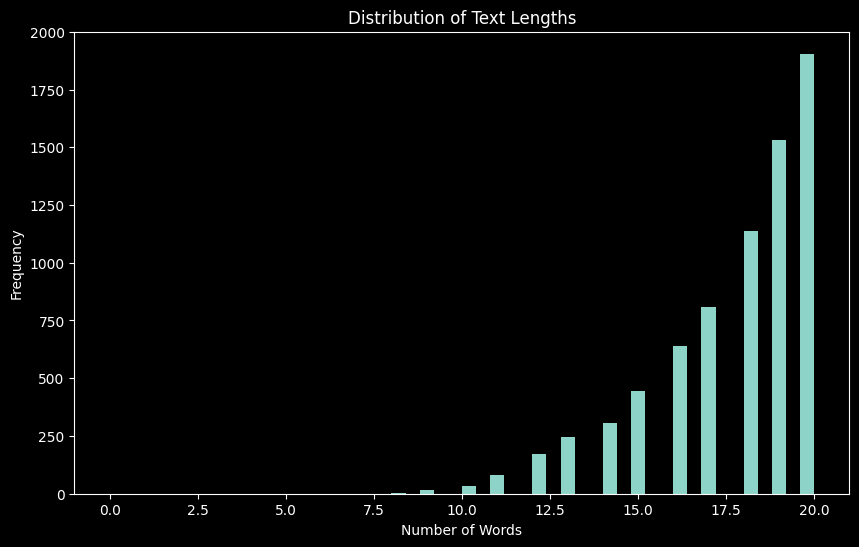

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(tattoos_dataset['text_length'], bins=50, range=(0,20))
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [14]:
tattoos_dataset = tattoos_dataset.filter(lambda x: x["text_length"] > 15)
tattoos_dataset

Filter:   0%|          | 0/78233 [00:00<?, ? examples/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length'],
    num_rows: 76931
})

## Retriever


### Embeddings


In [15]:
model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

mps


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [17]:
def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

In [18]:
def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

In [19]:
embedding = get_embeddings(tattoos_dataset["text"][0])
embedding.shape


torch.Size([1, 768])

In [20]:
if os.path.exists("data/tattoos_embeddings"):
    embeddings_dataset = Dataset.load_from_disk("data/tattoos_embeddings")
else:
    embeddings_dataset = tattoos_dataset.map(
        lambda x: {"embeddings": get_embeddings(x["text"]).detach().cpu().numpy()[0]}
    )
    # Create data directory if it doesn't exist
    os.makedirs("data", exist_ok=True)
    # Save the dataset with embeddings 
    embeddings_dataset.save_to_disk("data/tattoos_embeddings")

### Faiss Index


In [21]:
embeddings_dataset.add_faiss_index(column="embeddings")

  0%|          | 0/77 [00:00<?, ?it/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length', 'embeddings'],
    num_rows: 76931
})

### Evaluation TODO


In [22]:

question_embedding = get_embeddings([question]).cpu().detach().numpy()
question_embedding.shape

(1, 768)

In [23]:
scores, samples = embeddings_dataset.get_nearest_examples(
    "embeddings", question_embedding, k=15
)

In [24]:
samples_df = pd.DataFrame.from_dict(samples)
samples_df["scores"] = scores
samples_df.sort_values("scores", ascending=False, inplace=True)

In [25]:
samples_df.to_csv("example.csv")

In [26]:
for _, row in samples_df.iterrows():
    print(f"SCORE: {row.scores}")
    print(f"DESCRIPTION: {row.tattoo_description}")
    print(f"COLOR: {row.tattoo_color}")
    print(f"STYLE: {row.tattoo_style}")
    print(f"CONTENT: {row.Content}")
    print(f"TITLE: {row.Title}")
    print("=" * 50)
    print()

SCORE: 27.440597534179688
DESCRIPTION: a small cute cat tattoo on the wrist
COLOR: black
STYLE: illustrative
CONTENT: 
TITLE: Decided to get my cat drawing tattooed - Aric Love Sick Tattoo, Singapore

SCORE: 27.261226654052734
DESCRIPTION: a detailed tattoo featuring a cat and red flowers on a person's skin
COLOR: black red
STYLE: illustrative
CONTENT: First photo is from my tattoo artist , swipe to see ful tattoo l
TITLE: My recent cat tattoo. What do you all think?

SCORE: 27.229270935058594
DESCRIPTION: a detailed japanese tattoo design featuring a cat and floral patterns
COLOR: black
STYLE: japanese
CONTENT: 
TITLE: As I can't tattoo right now, I'm working on illustrations. People come to get my cats tattooed :) this one is a work in progress measuring 27.5" x 22.5"! You can watch my Work In Progress stories on Instagram @Majoras.Ink.Art

SCORE: 27.18843650817871
DESCRIPTION: colorful illustrative tattoo featuring cats and various elements
COLOR: multicolored
STYLE: illustrative
CO

## Re-ranker


In [27]:
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-12-v2")

In [28]:
scores_re_ranker = model.predict([(question, row.text) for _, row in samples_df.iterrows()])
samples_df["scores_re_ranker"] = scores_re_ranker
samples_df.sort_values("scores_re_ranker", ascending=False, inplace=True)
samples_df

,post_id,tattoo_description,tattoo_color,tattoo_style,Title,Unnamed: 0,Content,text,text_length,embeddings,scores,scores_re_ranker
0,1bfkzna,a detailed tattoo of a cat in a military uniform,multicolored,illustrative,Minimalish tattoo cat done by me,133897,,Minimalish tattoo cat done by me \n \n a deta...,18,"[0.22137339413166046, -0.2604624629020691, -0....",25.191891,-0.505548
1,1bfkzna,a detailed cat tattoo in a frame wearing a uni...,multicolored,illustrative,Minimalish tattoo cat done by me,133897,,Minimalish tattoo cat done by me \n \n a deta...,18,"[0.18070100247859955, -0.3371144235134125, -0....",25.796082,-1.010428
4,ti1cn2,a black cat with red horns and skulls on its k...,black red,illustrative,"More tattoo concepts, by me",90364,,"More tattoo concepts, by me \n \n a black cat...",24,"[0.27158644795417786, -0.5842545032501221, -0....",26.534479,-1.231272
7,kyrlkh,colorful traditional tattoo with text and cat ...,multicolored,traditional,Cat tattoo covering one of my self harm scars....,237145,,Cat tattoo covering one of my self harm scars....,28,"[0.16403518617153168, -0.2800672650337219, -0....",26.899387,-1.626353
13,1arl7ow,a detailed tattoo featuring a cat and red flow...,black red,illustrative,My recent cat tattoo. What do you all think?,131666,"First photo is from my tattoo artist , swipe t...",My recent cat tattoo. What do you all think? \...,39,"[0.2894357144832611, -0.2881090044975281, -0.2...",27.261227,-1.958107
11,xy3e1z,colorful illustrative tattoo featuring cats an...,multicolored,illustrative,"I Heard Reddit Likes Cats? By Hanna Calavera, ...",266156,,"I Heard Reddit Likes Cats? By Hanna Calavera, ...",21,"[0.38302546739578247, -0.2573104798793793, -0....",27.188437,-2.332271
3,yheif3,a cat with flowers and a necklace detailed bla...,black,illustrative,"Someone asked me for a tattoo design, looks good?",100387,,"Someone asked me for a tattoo design, looks go...",21,"[0.17462652921676636, -0.37783318758010864, -0...",25.916533,-2.524929
14,19alb6m,a small cute cat tattoo on the wrist,black,illustrative,Decided to get my cat drawing tattooed - Aric ...,299576,,Decided to get my cat drawing tattooed - Aric ...,23,"[0.2400284856557846, -0.4044131636619568, -0.3...",27.440598,-2.633239
9,xy3e1z,colorful illustrative tattoo featuring a cat f...,multicolored,illustrative,"I Heard Reddit Likes Cats? By Hanna Calavera, ...",266156,,"I Heard Reddit Likes Cats? By Hanna Calavera, ...",23,"[0.3687899112701416, -0.27220726013183594, -0....",27.094482,-2.737577
2,13qfpnw,a cat sitting in a box with a book and a pencil,black,illustrative,What do you guys think of my tattoo? It is my ...,110679,,What do you guys think of my tattoo? It is my ...,40,"[0.3334457278251648, -0.37999147176742554, -0....",25.833893,-2.739559


## TODO

1. Zbiór testowy 100 dokumentów 20 pytań
   - Tematy z naszej analizy AMC
2. Ewentualnine zbiór treningowy, którym doszkolimy reranker, (podał przykład augumentacji 1 prawidłowa odpowiedź i 1 zła)
3. RAG -- bardziej skomplikowane pytania, streszczenie wyszukiwań
4. Ewaluacja

## Done:

1. Część 1:

- Zad 2. (EWENTUALNIE ROZBUDOWAĆ B bo słabo jest opracowane)
- Zad 3. a, c,
- Zad 4. a, b

2. Część 2:

- Zad 1.
- Zad 2.
- Zad 3.


# RAG


In [29]:
k_for_rag = 10
top_k_docs = samples_df.head(k_for_rag)
context = "\n\n".join(top_k_docs["text"].tolist())

In [30]:
prompt = f"""
Context information is below.
---------------------
{context}
---------------------
Given the context information and not prior knowledge, answer the query.
Question: {question}
Answer:
"""

print(prompt)


Context information is below.
---------------------
Minimalish tattoo cat done by me 
  
 a detailed tattoo of a cat in a military uniform 
 multicolored 
 illustrative

Minimalish tattoo cat done by me 
  
 a detailed cat tattoo in a frame wearing a uniform 
 multicolored 
 illustrative

More tattoo concepts, by me 
  
 a black cat with red horns and skulls on its kittens surrounded by a circular line 
 black red 
 illustrative

Cat tattoo covering one of my self harm scars. Done by Palos at Transcendent Tattoo Collective in STL. 
  
 colorful traditional tattoo with text and cat imagery 
 multicolored 
 traditional

My recent cat tattoo. What do you all think? 
 First photo is from my tattoo artist , swipe to see ful tattoo l 
 a detailed tattoo featuring a cat and red flowers on a person's skin 
 black red 
 illustrative

I Heard Reddit Likes Cats? By Hanna Calavera, Whispering Weeds,Bristol, UK 
  
 colorful illustrative tattoo featuring cats and various elements 
 multicolored 
 

In [31]:
url = "https://services.clarin-pl.eu/api/v1/oapi/chat/completions"
user_token = os.getenv('CLARIN_API_TOKEN')


headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {user_token}",
    "Content-Type": "application/json"
}

payload = {
    "model": "llama",
    "messages": [
        {
            "role": "user",
            "content": prompt
        }
    ]
}

response = requests.post(url, headers=headers, json=payload)

In [32]:
if response.status_code == 200:
    data = response.json()

    assistant_message = data['choices'][0]['message']['content']
    print(assistant_message)

else:
    print(f"Failed to fetch data. Status code: {response.status_code}")
    print("Response:", response.text)

Based on provided context, here are the summaries:

1. Detailed cat in military uniform or framed uniform in multiple colors by the poster themselves.
2. Black cat in red attire with skulls surrounding its kittens within a circle in black and red ink by the poster.
3. Colorful traditional design covering a self-harm scar, depicting a cat with text and imagery by an artist at Transcendent Tattoo Collective in STL.
4. A colorful and detailed cat tattoo featuring red flowers by the poster's own artist; first image represents just part of the tattoo, whereas further images show it fully.
5. Multicolored illustrative cat designs, as per "I heard reddit likes cats," designed by Hanna Calavera at Whispering Weeds in Bristol, UK.
6. Small delicate black-work cat illustration on a wrist through a drawing made into a tattoo by Aric Love Sick tattoo artist in Singapore.
7. Minimalistic yet detailed illustration of a cat sitting on a box holding a pencil and book, likely based on a child's art sty